**Group 22**

Name  | Surname | Email  
---------|-------------------|---------
Julio|Vigueras|20220661@novaims.unl.pt 
Ariel|Pérez|20220662@novaims.unl.pt
Miguelanguel|Mayuare|20220665@novaims.unl.pt
Ayotunde|Aribo|20221012@novaims.unl.pt

# Model Handcrafted "A"
---

In this notebook, a simple model is applied to start an approach toward an optimal result. 

In [ ]:
# Make the imports
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib
import plotly.express as px
import pandas as pd

2023-04-06 17:30:44.300369: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 17:30:44.944136: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!wget https://www.dropbox.com/s/n3320qxwdn3rs19/moths.zip?dl=0 -O moths.zip
!unzip moths.zip

Mounted at /content/gdrive/


In [ ]:
dataset_path = pathlib.Path("moths")
input_shape = (224, 224, 3)

In [ ]:
# Function to define a convolutional neural network
def base_model(blocks=4, input_shape=(224, 224, 3)):
    # Input layer that defines the shape of the input data. 
    # In this case, the input is expected to be an image with a shape of (224, 224, 3).
    inputs = keras.Input(shape=input_shape)
    # This layer scales the image pixel values in the range from 0 to 1. 
    x = layers.Rescaling(1./255)(inputs)
    # This loop defines several convolution and pooling layers. 
    # The number of layers depends on the value of blocks, which is set to 4 by default. 
    # In each iteration of the loop, a convolution layer with 2^i filters 
    # and a 'relu' activation function is defined, 
    # followed by a pooling layer with a window size of 2x2.
    for i in range(blocks + 1, blocks + 5):  
        x = layers.Conv2D(filters=2**i, kernel_size=3, activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
    # This layer defines a convolution layer with 256 filters and an activation function 'relu'.
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x) 
    # This layer flattens the output data of the previous layer 
    # into a one-dimensional vector so that it can be processed by a dense layer.
    x = layers.Flatten()(x)
    # This layer defines the output layer with 30 units and a 
    # softmax activation function to classify the images into 30 categories.
    outputs = layers.Dense(30, activation="softmax")(x) 
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


The base model starts very simple, applying 3 blocks of `Conv2D` next to a `Maxpooling2D` layer in order to downsample the the inputs but retaining important information from images (Y. Lecun, 1998).

In [ ]:
model = base_model(3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                         

2023-04-06 17:30:52.957939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 17:30:52.977277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 17:30:52.977508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

For compile the model is used the next parameters:

* The **sparse_categorical_crossentropy** loss function is used when the labels are integers instead of one-hot encodings. It is suitable for multi-class classification and measures the difference between the predicted output and the true labels.
* The **adam** optimizer is a popular optimization algorithm that adjusts network weights during training. Adam automatically adapts to the learning rates of each weight to improve the speed and quality of training.
* The **accuracy** metric is a commonly used measure to evaluate the performance of a classification model. It indicates the proportion of test samples that are correctly classified into the target classes.

In [ ]:
# Compile model
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

The next code loads the image data into three separate data sets: training, validation and testing. Each dataset contains images of different classes and will be used to train, fit and evaluate the convolutional neural network model that has been defined.

In [ ]:
# Split datasets
train_dataset = image_dataset_from_directory(
    dataset_path / "train",
    image_size=input_shape[:2],
    batch_size=64)
validation_dataset = image_dataset_from_directory(
    dataset_path / "valid",
    image_size=input_shape[:2],
    batch_size=64)
test_dataset = image_dataset_from_directory(
    dataset_path / "test",
    image_size=input_shape[:2],
    batch_size=64)

Found 3558 files belonging to 30 classes.
Found 445 files belonging to 30 classes.
Found 408 files belonging to 30 classes.


Callbacks are defined in the next code to save the best model weights and stop training if the accuracy in the validation set does not improve after a given number of epochs.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="saved_models/model_handcrafted_A.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15)
]

In [ ]:
# Training model
history = model.fit(
    train_dataset,
    epochs=100,
    batch_size=64,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100


2023-04-06 17:31:11.542868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3558]
	 [[{{node Placeholder/_4}}]]
2023-04-06 17:31:11.543050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3558]
	 [[{{node Placeholder/_0}}]]
2023-04-06 17:31:12.688852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-06 17:31:13.438621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-06 1

56/56 [==============================] - ETA: 0s - loss: 2.7397 - accuracy: 0.2119

2023-04-06 17:31:19.478393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [445]
	 [[{{node Placeholder/_4}}]]
2023-04-06 17:31:19.478663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [445]
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - 8s 70ms/step - loss: 2.7397 - accuracy: 0.2119 - val_loss: 1.9248 - val_accuracy: 0.4472
Epoch 2/100
56/56 [==============================] - 2s 40ms/step - loss: 1.6990 - accuracy: 0.4955 - val_loss: 1.3907 - val_accuracy: 0.5933
Epoch 3/100
56/56 [==============================] - 2s 41ms/step - loss: 1.3357 - accuracy: 0.6048 - val_loss: 1.2017 - val_accuracy: 0.6472
Epoch 4/100
56/56 [==============================] - 2s 40ms/step - loss: 1.0339 - accuracy: 0.6858 - val_loss: 1.2273 - val_accuracy: 0.6517
Epoch 5/100
56/56 [==============================] - 2s 40ms/step - loss: 0.8220 - accuracy: 0.7496 - val_loss: 1.0959 - val_accuracy: 0.6764
Epoch 6/100
56/56 [==============================] - 2s 41ms/step - loss: 0.5451 - accuracy: 0.8288 - val_loss: 0.9934 - val_accuracy: 0.7236
Epoch 7/100
56/56 [==============================] - 2s 41ms/step - loss: 0.3871 - accuracy: 0.8806 - val_loss: 1.3324 - val_accuracy: 0.6899
Epoch 8/100
56/56 

In [ ]:
# Create dataframe with trained model
hist_df = pd.DataFrame(history.history)

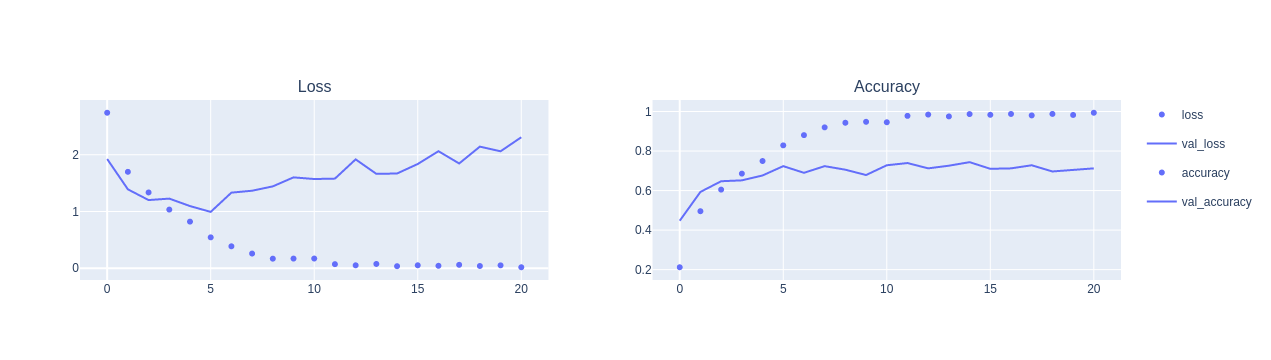

In [ ]:
# Visualization
from plotly.subplots import make_subplots
loss = px.scatter(hist_df['loss'])
val_loss = px.line(hist_df['val_loss'])
accuracy = px.scatter(hist_df['accuracy'])
val_accuracy = px.line(hist_df['val_accuracy'])

fig = make_subplots(cols=2, rows=1, subplot_titles=("Loss", "Accuracy"))
fig.add_trace(loss.data[0], col=1, row=1)
fig.add_trace(val_loss.data[0], col=1, row=1)
fig.add_trace(accuracy.data[0], col=2, row=1)
fig.add_trace(val_accuracy.data[0], col=2, row=1)

fig.show()

---
Visualizing the Loss Function and Accuracy, we can conclude that the model starts to overfit after the fourth epoch.